In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install neurokit2

In [50]:
import pickle
import pandas as pd
import numpy as np
import os
# Load data
pkl_file = '/content/drive/MyDrive/WESAD_pkl/S17.pkl'
subject_id = os.path.basename(pkl_file).split('.')[0]
with open(pkl_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Extract ECG and labels
ecg = data['signal']['chest']['ECG']  # shape (n_samples, 2)
labels = data['label']                # shape (n_samples,)

# Check shape
print("ECG shape:", ecg.shape)        # should be (5537, 2) or similar
print("Labels shape:", labels.shape)  # should be (same number of samples,)

# Use just the first ECG channel (e.g., lead I)
ecg_signal = ecg[:, 0]

# Ensure same length for DataFrame (truncate if needed)
min_len = min(len(ecg_signal), len(labels))
ecg_signal = ecg_signal[:min_len]
labels = labels[:min_len]

# Create DataFrame
df = pd.DataFrame({
    'ECG': ecg_signal,
    'Label': labels
})

# Duration in seconds
duration_seconds = len(ecg_signal) / 700
print(f"ECG Duration: {duration_seconds:.2f} seconds")

# Remove entries with labels 0, 5, 6, or 7
filtered_df = df[~df['Label'].isin([0, 5, 6, 7])].reset_index(drop=True)

# Check result
print(filtered_df['Label'].unique())
print(filtered_df.shape)


ECG shape: (4144000, 1)
Labels shape: (4144000,)
ECG Duration: 5920.00 seconds
[1 3 4 2]
(2104900, 2)


In [51]:

import neurokit2 as nk
import pandas as pd

# 30 seconds of ECG at 700Hz
sampling_rate = 700
ecg_segment = filtered_df['ECG'].values[:30 * sampling_rate]

# 1. Process ECG to detect peaks & clean signal
signals, info = nk.ecg_process(ecg_segment, sampling_rate=sampling_rate)

# 2. Extract HRV features
hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=sampling_rate, show=False)
print(hrv_features.T)





                        0
HRV_MeanNN     734.761905
HRV_SDNN       114.715514
HRV_SDANN1            NaN
HRV_SDNNI1            NaN
HRV_SDANN2            NaN
HRV_SDNNI2            NaN
HRV_SDANN5            NaN
HRV_SDNNI5            NaN
HRV_RMSSD       72.781547
HRV_SDSD        73.125991
HRV_CVNN         0.156126
HRV_CVSD         0.099055
HRV_MedianNN   704.285714
HRV_MadNN       84.720000
HRV_MCVNN        0.120292
HRV_IQRNN      126.428571
HRV_SDRMSSD      1.576162
HRV_Prc20NN    649.714286
HRV_Prc80NN    820.571429
HRV_pNN50       23.076923
HRV_pNN20       64.102564
HRV_MinNN      594.285714
HRV_MaxNN     1058.571429
HRV_HTI          7.800000
HRV_TINN        85.937500


In [52]:
import neurokit2 as nk
import pandas as pd
import numpy as np
from tqdm import tqdm

# Constants
sampling_rate = 700
window_duration = 30  # seconds
window_size = sampling_rate * window_duration

# Store HRV feature rows
feature_rows = []

# Iterate over non-overlapping 30-second windows
for start in tqdm(range(0, len(filtered_df) - window_size, window_size)):
    end = start + window_size
    ecg_window = filtered_df['ECG'].values[start:end]
    label_window = filtered_df['Label'].values[start:end]

    # Skip if multiple labels in window
    if len(np.unique(label_window)) > 1:
        continue

    label = label_window[0]

    try:
        # Step 1: Process ECG to get R-peaks
        signals, info = nk.ecg_process(ecg_window, sampling_rate=sampling_rate)

        # Step 2: Extract HRV time-domain features
        hrv_features = nk.hrv_time(signals['ECG_R_Peaks'], sampling_rate=sampling_rate, show=False)

        # Step 3: Attach label
        hrv_features['Label'] = label

        # Save
        feature_rows.append(hrv_features)

    except Exception:
        continue  # skip faulty segments

# Combine all features
hrv_dataset = pd.concat(feature_rows, ignore_index=True)

# Drop columns that are completely NaN
hrv_dataset.dropna(axis=1, how='all', inplace=True)

# Save to CSV
output_path = f"/content/hrv_features_labeled_{subject_id}.csv"
hrv_dataset.to_csv(output_path, index=False)

print(f"✅ HRV feature dataset saved to: {output_path}")


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]

✅ HRV feature dataset saved to: /content/hrv_features_labeled_S17.csv


In [83]:
import pandas as pd

# Read the CSV files
df1 = pd.read_csv("/content/hrv_features_labeled_S2.csv")
df2 =pd.read_csv("/content/hrv_features_labeled_S3.csv")
df3 = pd.read_csv("/content/hrv_features_labeled_S4.csv")
df4 = pd.read_csv("/content/hrv_features_labeled_S5.csv")
df5 = pd.read_csv("/content/hrv_features_labeled_S6.csv")
df6 = pd.read_csv("/content/hrv_features_labeled_S7.csv")
df7 = pd.read_csv("/content/hrv_features_labeled_S8.csv")
df8 = pd.read_csv("/content/hrv_features_labeled_S9.csv")
df9 = pd.read_csv("/content/hrv_features_labeled_S10.csv")
df10 = pd.read_csv("/content/hrv_features_labeled_S11.csv")
df11 = pd.read_csv("/content/hrv_features_labeled_S13.csv")
df12 = pd.read_csv("/content/hrv_features_labeled_S14.csv")
#df13 = pd.read_csv("/content/hrv_features_labeled_S15.csv")
#df14 = pd.read_csv("/content/hrv_features_labeled_S16.csv")
#df15 = pd.read_csv("/content/hrv_features_labeled_S17.csv")
# Concatenate the data (ignore the header in the second file)
merged_df = pd.concat([df1, df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], ignore_index=True)

# Write the merged data to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)


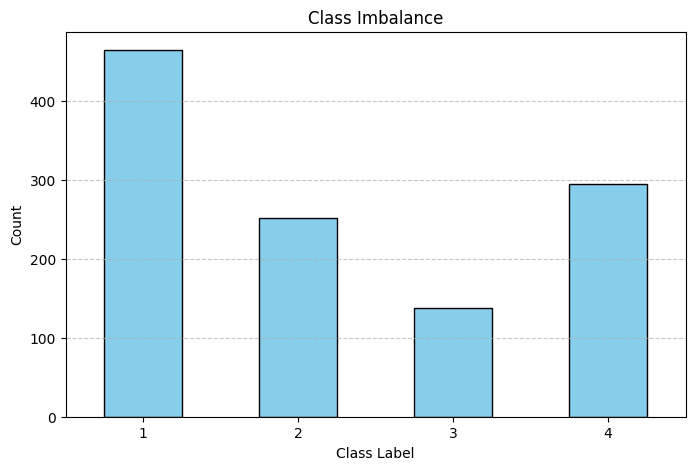

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your HRV features CSV
csv_path = '/content/drive/MyDrive/WESAD_pkl/merged_file.csv'  # change if needed
df = pd.read_csv(csv_path)

# Count the number of samples for each label
label_counts = df['Label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Before undersampling:
 Label
1    464
4    295
2    251
3    137
Name: count, dtype: int64

After undersampling:
 Label
4    251
2    251
1    251
Name: count, dtype: int64

✅ Balanced dataset saved to /content/hrv_features_balanced.csv


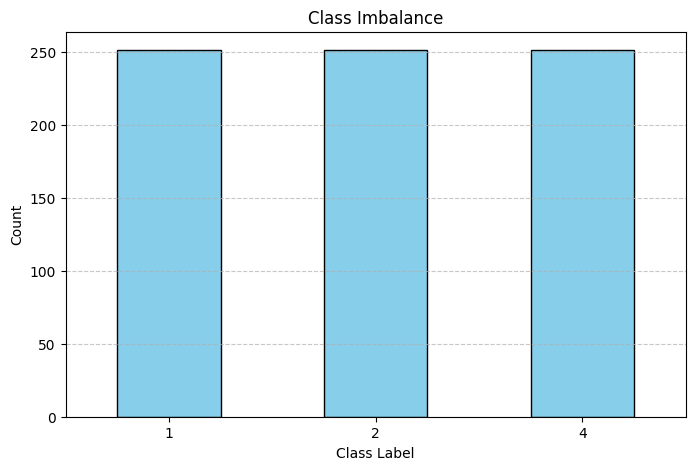

In [55]:
import pandas as pd

# Load dataset
csv_path = '/content/drive/MyDrive/WESAD_pkl/merged_file.csv'  # change if needed
df = pd.read_csv(csv_path)

# Count samples per class
class_counts = df['Label'].value_counts()
print("Before undersampling:\n", class_counts)

# Get count of class 2
class_2_count = class_counts[2]

# Split classes
class_1_df = df[df['Label'] == 1]
class_2_df = df[df['Label'] == 2]
class_3_df = df[df['Label'] == 3]
class_4_df = df[df['Label'] == 4]

# Undersample class 1
class_1_undersampled = class_1_df.sample(n=class_2_count, random_state=42)
class_4_undersampled=class_4_df.sample(n=class_2_count,random_state=42)

# Combine balanced dataset (1 and 2 are balanced, 3 and 4 are left untouched)
balanced_df = pd.concat([class_1_undersampled, class_2_df,class_4_undersampled], ignore_index=True)

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Count samples after undersampling
print("\nAfter undersampling:\n", balanced_df['Label'].value_counts())

# Save (optional)
balanced_df.to_csv('/content/hrv_features_balanced.csv', index=False)
print("\n✅ Balanced dataset saved to /content/hrv_features_balanced.csv")

label_counts = balanced_df['Label'].value_counts().sort_index()


# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Classification Report on Test Set:

              precision    recall  f1-score   support

           1       0.66      0.82      0.73        93
           2       0.73      0.64      0.68        50
           4       0.67      0.47      0.55        59

    accuracy                           0.67       202
   macro avg       0.68      0.64      0.65       202
weighted avg       0.68      0.67      0.67       202



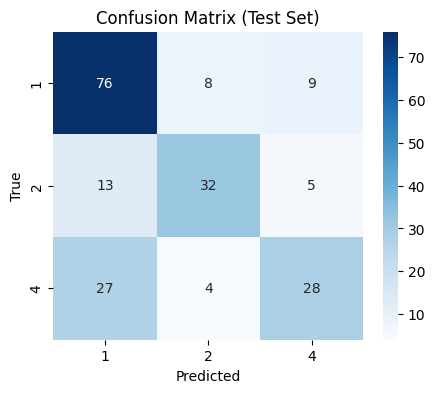

In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the balanced dataset
df = pd.read_csv('/content/merged_file.csv')

# ✅ Optionally drop label 3 if it's still included
df = df[df['Label'] != 3]

# Separate features and label
X = df.drop(columns=['Label'])
y = df['Label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# Train on training data
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation report
print("Classification Report on Test Set:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [31]:
import joblib

# Save the trained Random Forest model
joblib.dump(clf, '/content/random_forest_hrv.pkl')
print("✅ Model saved!")


✅ Model saved!


In [64]:
import pandas as pd
import joblib

# Load trained model
#clf = joblib.load('/content/random_forest_hrv.pkl')

# Load left-out subject features
test_df = pd.read_csv('/content/hrv_features_labeled_S16.csv')# <- change S11 to your left-out subject
test_df=test_df[test_df['Label'] != 3]

# Separate features and true labels
X_test = test_df.drop(columns=['Label'])
y_true = test_df['Label']

# Predict
y_pred = clf.predict(X_test)

# Create a DataFrame with true labels and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save to CSV file
result_df.to_csv('/content/predictions_results.csv', index=False)

# Optional: Classification report
from sklearn.metrics import classification_report
print("\n", classification_report(y_true, y_pred))



               precision    recall  f1-score   support

           1       0.77      0.44      0.56        39
           2       0.78      1.00      0.88        21
           4       0.37      0.54      0.44        24

    accuracy                           0.61        84
   macro avg       0.64      0.66      0.62        84
weighted avg       0.66      0.61      0.60        84



In [94]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load full dataset
df = pd.read_csv('/content/merged_file.csv')

# Drop label 3 if it's still present
df = df[df['Label'] != 3]

# Convert to binary stress label
df['BinaryLabel'] = df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and target
X = df.drop(columns=['BinaryLabel'])  # make sure SubjectID is excluded
y = df['BinaryLabel']

# Train Random Forest on full data
clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
clf.fit(X, y)

# Save model
joblib.dump(clf, 'stress_rf_model.pkl')
print("Model saved as 'stress_rf_model.pkl'")


Model saved as 'stress_rf_model.pkl'


In [86]:
print(df['BinaryLabel'].value_counts())


BinaryLabel
0    759
1    251
Name: count, dtype: int64


In [97]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# Load trained model
clf = joblib.load('/content/stress_rf_model.pkl')

# Load left-out subject features
test_df = pd.read_csv('/content/hrv_features_labeled_S15.csv')  # Change 'S16' to your left-out subject ID
test_df = test_df[test_df['Label'] != 3]  # Optionally drop label 3 if it exists

# Convert to binary: 1 = stress, 0 = no stress
test_df['BinaryLabel'] = test_df['Label'].apply(lambda x: 1 if x == 2 else 0)

# Separate features and true labels
X_test = test_df.drop(columns=['BinaryLabel'])  # Only drop 'BinaryLabel', but keep 'Label'
y_true = test_df['BinaryLabel']

# Predict using the trained model
y_pred = clf.predict(X_test)

# Create a DataFrame with true labels and predicted labels
result_df = pd.DataFrame({
    'True_Label': y_true,
    'Predicted_Label': y_pred
})

# Save the results to a CSV file
result_df.to_csv('/content/predictions_results.csv', index=False)

# Optional: Print the classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.95      0.98        22

    accuracy                           0.99        85
   macro avg       0.99      0.98      0.98        85
weighted avg       0.99      0.99      0.99        85

